In [24]:
import torch
torch.__version__

'2.9.0+cpu'

In [25]:
# for a fist time we will use a data created by ourselves, and it will be a simple linear function
weight = 0.7 # weight and bias will be used for y values
bias= 0.3

start= 0 
end= 2
step= 0.02

x= torch.arange(start , end, step)
y= weight * x + bias
print ("x: ", x[:10])
print("y: ",y[:10])


x:  tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
        0.1800])
y:  tensor([0.3000, 0.3140, 0.3280, 0.3420, 0.3560, 0.3700, 0.3840, 0.3980, 0.4120,
        0.4260])


In [26]:
# after getting data the next step is splitting it in to  training and testing
# usualy we have skit learn for this but for the current one we do spliting manually

train_split= int(0.7 * len(x)) # 70% of the data will be used for training
x_train= x[:train_split]
y_train= y[:train_split]

x_test= x[train_split:]
y_test= y[train_split:]

# Now to check they have equal length
len(x_train), len(y_train), len(x_test), len(y_test)

(70, 70, 30, 30)

In [27]:
import matplotlib.pyplot as plt
# Now to visualize the data we have we use matplotlib, lets create a function that we can reuse
def plot_prediction(train_data, train_label, test_data, test_label, prediction=None):
    plt.figure(figsize=(7,3))
    plt.scatter(train_data, train_label, c='g', s=3, label='Training data' ) # c is for color, s is for size of the dots
    plt.scatter(test_data, test_label, c='b', s=3 , label='Test data')
    
    if prediction is not None: 
        plt.scatter(test_data, prediction, c='r', s=3, label='Prediction' )
    
    plt.legend(prop={'size':14})
    

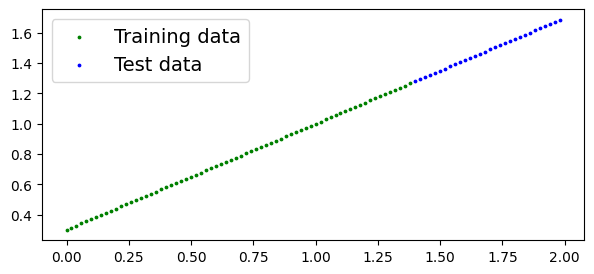

In [28]:
plot_prediction(x_train, y_train, x_test, y_test)

In [29]:
from torch import nn #nn contains all the building blocks for neural networks
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight= nn.Parameter(torch.randn(1, dtype=torch.float32, requires_grad=True))
        self.bias= nn.Parameter(torch.randn(1, dtype=torch.float32, requires_grad=True))
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.weight * x + self.bias

In [30]:
#ok now lets create an instance of the model we created above
torch.manual_seed(42) # we are doing this because in the model/class we created above we are generating random numbers
model_0 = LinearRegressionModel()
list(model_0.parameters()) # will give the values of the parameters
model_0.state_dict() # this will give the parameters with the values

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

tensor(0.6675)


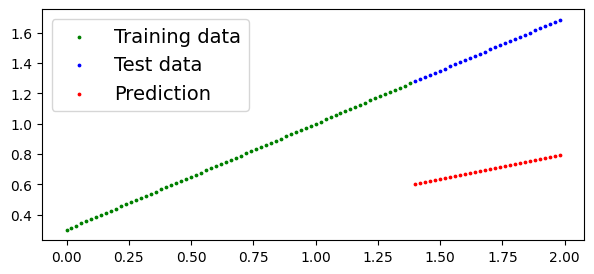

In [31]:
# Now that we have our model we can make prediction but since we have not trained it and it is random it will result in random result
with torch.inference_mode():
    y_pred= model_0(x_test)
# now the value of y pred is
print(y_pred[10])
# to see it plotted
plot_prediction(x_train, y_train, x_test, y_test, y_pred)

In [32]:
# ok now it is time to train
torch.manual_seed(42)
epochs= 100
lossFn= nn.L1Loss()
optimizer= torch.optim.SGD(params=model_0.parameters(), lr=0.01)
train_loss_values=[]
test_loss_values=[]
epoch_count= []
for epoch in range(epochs): 
    model_0.train()
    y_train_pred= model_0(x_train)
    loss= lossFn(y_train_pred, y_train)
    if epoch % 10 == 0:
        train_loss_values.append(loss.detach().item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_0.eval()
    if epoch % 10 == 0: 
        epoch_count.append(epoch)
        with torch.inference_mode():
            y_test_pred= model_0(x_test)
            test_loss= lossFn( y_test_pred , y_test)
            test_loss_values.append(test_loss.detach().item())
            print(f"epoch: {epoch} ---------- loss: {loss}")
            
    
    

epoch: 0 ---------- loss: 0.4218742549419403
epoch: 10 ---------- loss: 0.2742640972137451
epoch: 20 ---------- loss: 0.1311108022928238
epoch: 30 ---------- loss: 0.06120188534259796
epoch: 40 ---------- loss: 0.04335111379623413
epoch: 50 ---------- loss: 0.035122182220220566
epoch: 60 ---------- loss: 0.027280280366539955
epoch: 70 ---------- loss: 0.019441286101937294
epoch: 80 ---------- loss: 0.011605189181864262
epoch: 90 ---------- loss: 0.003769085742533207


In [33]:
print(model_0.state_dict())

OrderedDict({'weight': tensor([0.6958]), 'bias': tensor([0.2988])})


tensor(0.0084)


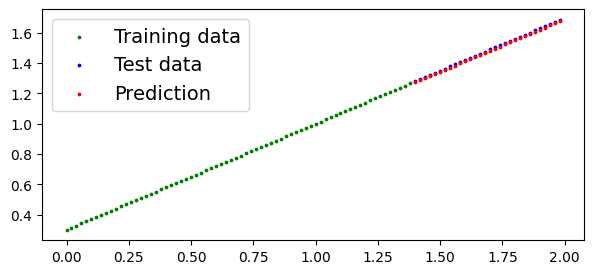

In [34]:
with torch.inference_mode():
    y_predict= model_0(x_test)
    y_test_loss= lossFn(y_predict, y_test)
plot_prediction(x_train, y_train, x_test, y_test, y_predict)
print(y_test_loss)

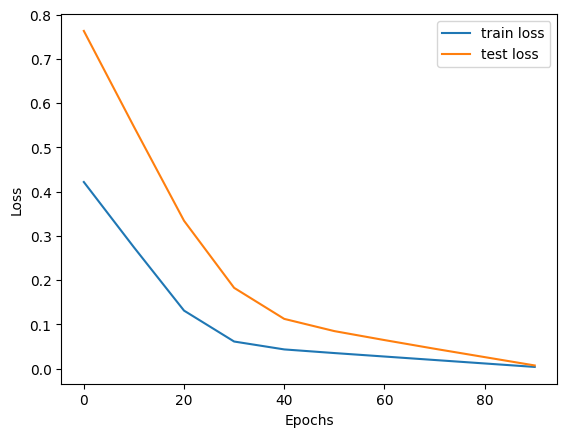

In [35]:
# now lets create the loss curve for both train and test
plt.plot(epoch_count, train_loss_values, label='train loss')
plt.plot(epoch_count, test_loss_values, label='test loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [36]:
# Saving and loading pytorch model
from pathlib import Path

MODEL_PATH= Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok= True)
MODEL_NAME= "pytorch_first_model_0.pth"
MODEL_SAVE_PATH= MODEL_PATH / MODEL_NAME
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(model_0.state_dict(), f=MODEL_SAVE_PATH)  # currently since this is executed on colab it will be stored on colab

Saving model to models/pytorch_first_model_0.pth


In [37]:
!ls models # this will show it is saved

pytorch_first_model_0.pth


In [38]:

# Now lets load it back
#Since what we did was saving the state dictionary and not the whole model  first we need to create instance of it
loaded_model_0= LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [39]:
#Now testing if our loaded model was our last saved model
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(x_test)

# Lets compare it to our last output of model_0 prediction
y_predict == loaded_model_preds

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True])